In [33]:
#!/usr/bin/env python

# This script converts GEDCOM genealogy members
# to the FHKB turtle semantic web ontology individuals.
# (A header with FHKB ontology definitions is still required.)
# TODO adoptive families (>1) are not considered (TODO?)
# Author: Evgeny Blokhin
# License: MIT
fileinput = "data/Ameta2.ged"
import os, sys
from gedcom import Gedcom

try: workpath = fileinput
except IndexError: sys.exit("No gedcom defined!")

def term2id(el):
    return "i" + el.pointer().replace('@', '').lower()

g = Gedcom(workpath)
gedcom_dict = g.element_dict()
individuals, marriages = {}, {}


for k, v in gedcom_dict.items():
    if v.is_individual():
        children, siblings = set(), set()
        idx = term2id(v)

        title = v.name()[0]+ " " + v.name()[1]
        title = title.replace('"', '').replace('[', '').replace(']', '').replace('(', '').replace(')', '').strip()

        own_families = g.families(v, 'FAMS')
        for fam in own_families:
            children |= set(term2id(i) for i in g.get_family_members(fam, "CHIL"))

        parent_families = g.families(v, 'FAMC')
        if len(parent_families):
            for member in g.get_family_members(parent_families[0], "CHIL"): # NB adoptive families i.e len(parent_families)>1 are not considered (TODO?)
                if member.pointer() == v.pointer():
                    continue
                siblings.add(term2id(member))

        if idx in individuals:
            children |= individuals[idx].get('children', set())
            siblings |= individuals[idx].get('siblings', set())
        individuals[idx] = {'sex': v.gender().lower(), 'children': children, 'siblings': siblings, 'title': title}

    elif v.is_family():
        wife, husb, children = None, None, set()
        children = set(term2id(i) for i in g.get_family_members(v, "CHIL"))

        try:
            wife = g.get_family_members(v, "WIFE")[0]
            wife = term2id(wife)
            if wife in individuals: individuals[wife]['children'] |= children
            else: individuals[wife] = {'children': children}
        except IndexError: pass
        try:
            husb = g.get_family_members(v, "HUSB")[0]
            husb = term2id(husb)
            if husb in individuals: individuals[husb]['children'] |= children
            else: individuals[husb] = {'children': children}
        except IndexError: pass

        if wife and husb: marriages[wife + husb] = (term2id(v), wife, husb)
            
f = open(fileinput+'.ttl', 'w')
fread = open('data/header.ttl','r')
for line in fread:
    f.write(line)
fread.close()
for idx, val in individuals.items():
    added_terms = ''
    if val['sex'] == 'f':
        parent_predicate, sibl_predicate = "isMotherOf", "isSisterOf"
    else:
        parent_predicate, sibl_predicate = "isFatherOf", "isBrotherOf"
    if len(val['children']):
        added_terms += " ;\n    fhkb:" + parent_predicate + " " + ", ".join(["fhkb:" + i for i in val['children']])
    if len(val['siblings']):
        added_terms += " ;\n    fhkb:" + sibl_predicate + " " + ", ".join(["fhkb:" + i for i in val['siblings']])
    f.write("fhkb:%s a owl:NamedIndividual, owl:Thing%s ;\n    rdfs:label \"%s\" .\n" % (idx, added_terms, val['title']))

for k, v in marriages.items():
    f.write("fhkb:%s a owl:NamedIndividual, owl:Thing ;\n    fhkb:hasFemalePartner fhkb:%s ;\n    fhkb:hasMalePartner fhkb:%s .\n" % v)

f.write("[] a owl:AllDifferent ;\n    owl:distinctMembers (")
for idx in individuals.keys():
    f.write("    fhkb:" + idx)
for k, v in marriages.items():
    f.write("    fhkb:" + v[0])
f.write ("    ) .")
f.close()


In [34]:
import os, sys
import time

import rdflib
import RDFClosure
from RDFClosure import DeductiveClosure, OWLRL_Extension

try: workpath = fileinput+'.ttl'
except IndexError: sys.exit("No path defined!")
try: recursion_limit = int(0)
except IndexError: recursion_limit = 0

if recursion_limit > 0: sys.setrecursionlimit(recursion_limit)

g = rdflib.Graph()
g.parse(workpath, format="turtle")

print ("Recursion stack limit:", sys.getrecursionlimit())
print ("Triples before:", len(g))
starttime = time.time()
DeductiveClosure(OWLRL_Extension).expand(g)
print ("Done in %1.2f sec" % (time.time() - starttime))
print ("Triples after:", len(g))

f = open(fileinput + ".inferred", "wb")
f.write(g.serialize(format="turtle"))
f.close()

Recursion stack limit: 1000
Triples before: 725
Done in 8.42 sec
Triples after: 4674


In [35]:
#!/usr/bin/env python

import os, sys
import json

import rdflib


RELS_TO_DRAW = ['isWifeOf', 'isMotherOf', 'isFatherOf']
RELS_TO_INFER = ['hasGrandParent', 'isGrandParentOf', 'hasGreatGrandParent', 'isGreatGrandParentOf', 'isUncleOf', 'hasUncle', 'isGreatUncleOf', 'hasGreatUncle', 'isAuntOf', 'hasAunt', 'isGreatAuntOf', 'hasGreatAunt', 'isFirstCousinOf', 'isSecondCousinOf', 'isThirdCousinOf']
RELS_OF_INTEREST = RELS_TO_DRAW + RELS_TO_INFER

try: workpath = fileinput + ".inferred" 
except IndexError: sys.exit("No path defined!")
try: recursion_limit = 0
except IndexError: recursion_limit = 0

if recursion_limit > 0: sys.setrecursionlimit(recursion_limit)

g = rdflib.Graph()
g.parse(workpath, format="turtle")

triples = []

FHKB = rdflib.Namespace("http://www.example.com/genealogy.owl#")

def dump(uriref):
    return uriref.split('#')[-1]

for i in g.subjects(object=FHKB.Person):
    for p, o in g.predicate_objects(subject=i):
        if p.startswith(FHKB) and dump(p) in RELS_OF_INTEREST:
            triples.append({'source': dump(i), 'target': dump(o), 'type': dump(p)})
    for o in g.objects(subject=i, predicate=rdflib.RDFS.label):
        triples.append({'source': dump(i), 'target': o, 'type': 'label'})
f = open(fileinput + '.inferred' + '.json','w')
f.write(json.dumps(triples, indent=0))
f.close()

Nodes:Madhavi Ameta ID:ii0040
Nodes:Jyoti Ameta ID:ii0007
Nodes:Sagarika Ameta ID:ii0041
Nodes:Radha Vallabh Vyas ID:ii0013
Nodes:Laxmi lal Ameta ID:ii0014
Nodes:Jayesh Ameta ID:ii0030
Nodes:Virendra Ameta ID:ii0016
Nodes:Dilip Ameta ID:ii0018
Nodes:Himanshu Dwivedi ID:ii0020
Nodes:Shanti Devi Vyas ID:ii0011
Nodes:Manju Ameta ID:ii0008
Nodes:Dhruv Ameta ID:ii0036
Nodes:Nidhi Ameta ID:ii0035
Nodes:Kusum Ameta ID:ii0005
Nodes:Rohit Vyas ID:ii0026
Nodes:Shyama Ameta ID:ii0037
Nodes:Usha Ameta ID:ii0001
Nodes:Aarjav Ameta ID:ii0033
Nodes:Varun Ameta ID:ii0039
Nodes:Bharat Raj Ameta ID:ii0009
Nodes:Pushpa Vyas ID:ii0021
Nodes:Prateek Ameta ID:ii0006
Nodes:Gayatri Vyas ID:ii0027
Nodes:Yogvit Ameta ID:ii0003
Nodes:Rajendra Ameta ID:ii0017
Nodes:Gaurav Ameta ID:ii0000
Nodes:Anusuya Vyas ID:ii0022
Nodes:Sagar Devi Ameta ID:ii0015
Nodes:Chandra Ameta ID:ii0038
Nodes:Govind Vallabh Vyas ID:ii0012
Nodes:Aena Vyas ID:ii0028
Nodes:Gagan Vyas ID:ii0024
Nodes:Sameera Thangudu Ameta ID:ii0019
Nodes:Pra

C:\Users\gna\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\gna\AppData\Local\Continuum\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\gna\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\gna\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is depreca

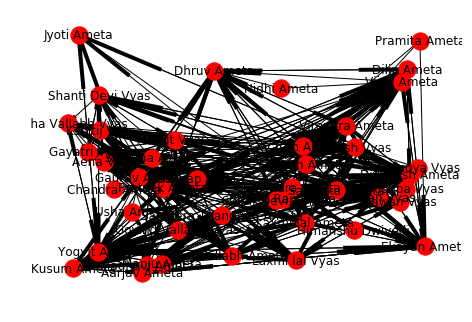

In [97]:
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt

G=nx.MultiDiGraph()
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

filename = fileinput + '.inferred' + '.json'
my_id = []
name = []
count = 1;
with open(filename) as f:
    js_graph = json.load(f)
    #add nodes
    for line in js_graph:
        #print(line)
        #print("---------------")
        fun = str(line)
        i = fun.find("'type': 'label'") 
        if i>0:
            #print(fun)
            name.append(find_between(fun,"'target': '", "', 'type': '"))
            my_id.append(find_between(fun,"{'source': '", "', 'target': '"))
            
            G.add_node(name[-1],id=my_id[-1])
            count= count+1;
            print("Nodes:"+name[-1]+" ID:"+my_id[-1])
    #add edges
    for line in js_graph:
        #print(line)
        #print("---------------")
        fun = str(line)
        i = fun.find("'type': 'label'") 
        if i<0:
            #print(fun)
            source = find_between(fun,"'source': '", "', 'target':")
            target = find_between(fun,"'target': '", "', 'type':")
            if any(source in s for s in my_id):
                if any(target in s for s in my_id):
                    
                    G.add_edge(name[my_id.index(source)],name[my_id.index(target)],label=find_between(fun,"'type': '", "'}"))
                    
                    print(name[my_id.index(source)]+"-->",find_between(fun,"'type': '", "'}")+"-->"+name[my_id.index(target)])
            #print(find_between(fun,"'type': '", "'}"))

#return json_graph.node_link_graph(js_graph)

f.close()

nx.draw_random(G,with_labels=True)  # networkx draw()
plt.show()
